Jordan Smith

Spring 2023

CS 251: Data Analysis and Visualization

Project 7: Radial Basis Function Neural Networks

In [26]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use(['seaborn-v0_8-colorblind', 'seaborn-v0_8-darkgrid'])
plt.rcParams.update({'font.size': 20})

np.set_printoptions(suppress=True, precision=5)

# Automatically reload external modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Task 1: RBF Network development dataset

The eventual goal is to train a neural network so that it learns to recognize which human handwritten digit is shown in an image  (i.e. the numbers 0, 1, ..., 9). Before doing this, you will use simpler data to develop and debug your network.

### 1a. Load and preprocess data

- Load in the `rbf_dev_train.csv` and `rbf_dev_test.csv` train and test sets.
- For the train and test sets, separate the data variables (`X` and `Y`) from the class values (*class*). The test code below assumes the following names:
    - `y_train` and `y_test` for the class values in the train and test sets, respectively.
    - `rbf_dev_train` and `rbf_dev_test` for the train and test set data, respectively.
- Normalize each data feature "separately" between 0 and 1 (based on each feature's dynamic range).
    - Use the `min` and `max` values derived from the training set to normalize the test set. *This will ensure that identical feature values in the training and test sets get normalized to the same numeric value.*

**Tip:** It might be a good idea to write a few functions below so that you don't have a lot of duplicate code when processing train and test sets.

In [27]:
train = pd.read_csv("data/rbf_dev_train.csv")
test = pd.read_csv("data/rbf_dev_test.csv")
train = np.array(train)
test = np.array(test)

rbf_dev_train = train[:,:2]
rbf_dev_test = test[:,:2]

y_train = train[:,2]
y_test = test[:,2]

rbf_dev_train = (rbf_dev_train - np.min(rbf_dev_train)) / (np.max(rbf_dev_train)-np.min(rbf_dev_train))
rbf_dev_test = (rbf_dev_test - np.min(rbf_dev_test)) / (np.max(rbf_dev_test)-np.min(rbf_dev_test))




#### Preprocessing test code

The following test code is a good sanity check, but you are encouoraged to do additional testing to make sure that your preprocessing pipeline is working properly.

##### Check dtypes

In [28]:
print(f'Your training set is an ndarray? {isinstance(rbf_dev_train, np.ndarray)}')
print(f'Your training classes is an ndarray? {isinstance(y_train, np.ndarray)}')
print(f'Your test set is an ndarray? {isinstance(rbf_dev_test, np.ndarray)}')
print(f'Your test classes is an ndarray? {isinstance(y_test, np.ndarray)}')

Your training set is an ndarray? True
Your training classes is an ndarray? True
Your test set is an ndarray? True
Your test classes is an ndarray? True


##### Check shapes

In [29]:
print(f'Your training set shape is {rbf_dev_train.shape} and should be (1600, 2).')
print(f'Your training classes shape is {y_train.shape} and should be (1600,).')
print(f'Your test set shape is {rbf_dev_test.shape} and should be (400, 2).')
print(f'Your test classes shape is {y_test.shape} and should be (400,).')

Your training set shape is (1600, 2) and should be (1600, 2).
Your training classes shape is (1600,) and should be (1600,).
Your test set shape is (400, 2) and should be (400, 2).
Your test classes shape is (400,) and should be (400,).


### 1b. Plot data

Create a scatter plot of the training data in the cell below.

- Color code each sample by its output class.
- Make the aspect ratio (height and width) of the x and y axes in the figure equal, otherwise the plot may look distorted.

If everything is working properly, you should see a jack-o-lantern whose eyes, noise, mouth, and stem are colored differently than the rest of the face.

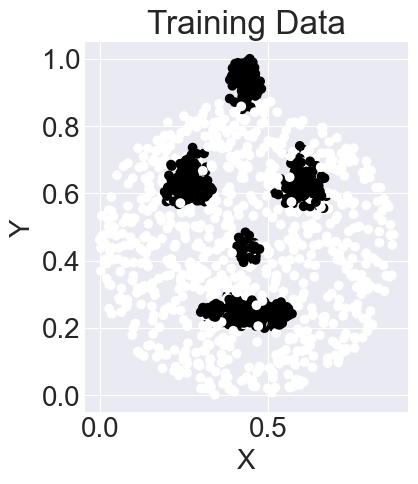

In [30]:
plt.scatter(rbf_dev_train[:, 0], rbf_dev_train[:, 1], c=y_train)

plt.gca().set_aspect('equal')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Training Data')

plt.show()

## Task 2: Radial basis function neural network

In [31]:
from rbf_net import RBF_Net

### 2a. Network initalization

You will use K-means to initialize the RBF hidden layer prototypes and sigmas.

1. Copy over your `kmeans.py` from your previous project. If your K-means clustering code isn't working properly, you may use `scipy` functions in this project instead, but at a 1 point reduction. Check out `scipy.cluster.vq.kmeans`.

2. Implement the method templates in `rbf.py` that initialize the hidden layer of the neural network:
    - Finish writing the constructor
    - `get_num_hidden_units`
    - `get_num_output_units`
    - `avg_cluster_dist`: Compute the average distance between each cluster center found by K-means and all the points assigned to the same cluster.
    - `initialize`: Use K-means to set the Gaussian hidden unit centers (**prototypes**) and standard deviations (**sigmas**).


In [32]:
from kmeans import KMeans

#### Test `avg_cluster_dist`

In [33]:
np.random.seed(0)

# N = 10 samples, M = 5 features
test_data = np.random.normal(size=(10, 5))
# 4 hidden units / prototypes, each has 5 features
test_centroids = np.random.normal(size=(4, 5))
# Each sample assigned to one of 4 hidden unit prototypes
test_assignments = np.random.randint(low=0, high=4, size=(10,))
kmeansObj = KMeans()

test_net = RBF_Net(4, 3)
print(f'Number of hidden units in your net is {test_net.get_num_hidden_units()} and should be 4')
print(f'Number of output units in your net is {test_net.get_num_output_units()} and should be 3')
test_clust_mean_dists = test_net.avg_cluster_dist(test_data, test_centroids, test_assignments, kmeansObj)

print(f'Your avg within cluster distances are\n{test_clust_mean_dists} and should be\n[2.23811 3.94891 3.12267 3.4321]')

Number of hidden units in your net is 4 and should be 4
Number of output units in your net is 3 and should be 3
Your avg within cluster distances are
[2.23811 3.94891 3.12267 3.4321 ] and should be
[2.23811 3.94891 3.12267 3.4321]


#### Test `initialize`

In [34]:
np.random.seed(0)
test_net.initialize(test_data)

print(f'Your prototypes have shape {test_net.get_prototypes().shape} and the shape should be (4, 5).')
print(f'Your hidden unit sigmas have shape {test_net.sigmas.shape} and the shape should be (4,).')

K-means converged after 2 iterations
K-means converged after 2 iterations
K-means converged after 2 iterations
K-means converged after 2 iterations
K-means converged after 3 iterations
Your prototypes have shape (4, 5) and the shape should be (4, 5).
Your hidden unit sigmas have shape (4,) and the shape should be (4,).


#### Test initialization methods

In the cell below, write test code for your RBF network initialization:
- Create a new RBF network with 7 hidden units and 2 output classes.
- Call the `initalize` method on it, passing in the training data.
- Create a class color-coded scatterplot of the training data with an equal axis aspect ratio, like above, now with the prototypes clearly marked with a different marker and/or color.

You should see fairly evenly distributed prototypes, with one in most, if not all, "pockets" of samples belonging to a single class.

K-means converged after 7 iterations
K-means converged after 9 iterations
K-means converged after 16 iterations
K-means converged after 23 iterations
K-means converged after 7 iterations


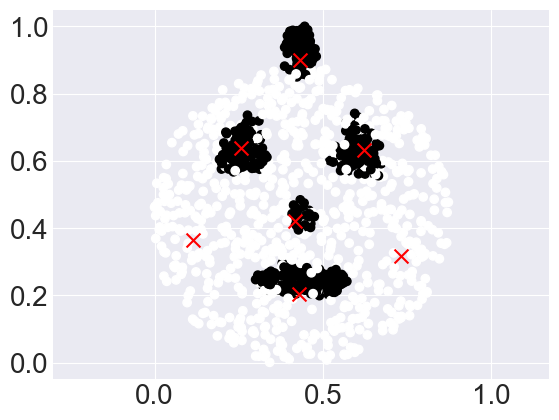

In [35]:
np.random.seed(0)

# Create the RBF network
rbf_net = RBF_Net(num_hidden_units=7, num_classes=2)

# Initialize the network
rbf_net.initialize(rbf_dev_train)

plt.scatter(rbf_dev_train[:, 0], rbf_dev_train[:, 1], c=y_train)
plt.scatter(rbf_net.prototypes[:, 0], rbf_net.prototypes[:, 1], marker='x', s=100, c='r')
plt.axis('equal')
plt.show()

**Question 1:** Do you think the prototypes enable the RBF network to learn the data well? Why or why not?

**Answer 1:** 

I think the prototypes enabled the RBF network to learn the data well because the cluster centers idenitfy the five black clusters and are centered symterically among the white part.

### 2b. Compute hidden and output layer activations

Implement the following methods so that you can train your RBF network:
- `hidden_act`: Computes hidden layer activation values: Determines the similarity between hidden layer prototypes with the input data.
- `output_act`: Computes output layer activation values: Multiply hidden unit activation by output unit weights.

**Hidden unit activation**:

The activation of hidden unit $j$ to data sample $i$ is computed according to $$H_{ij} = \exp \left (-\frac{\text{dist} \left (\vec{x}_i, \vec{c}_j \right )^2}{2\sigma_j^2 + \epsilon}\right )$$ 
where $\vec{x_i}$ is the data sample, $\vec{c_j}$ is the prototype (center) of the hidden unit, $\sigma_j$ is the hidden unit's standard deviation, $\epsilon$ is a small number (e.g. 1e-8), and $dist(\cdot, \cdot)^2$ is the **squared** Euclidean distance.

#### Test hidden_act

In [36]:
np.random.seed(1)

# N = 3 samples, M = 5 features
test_data = np.random.normal(size=(3, 5))
# 4 hidden units / prototypes, each has 5 features
test_centroids = np.random.normal(size=(4, 5))
# Each sample assigned to one of 4 hidden unit prototypes
test_sigmas = np.random.uniform(size=(4,))
test_wts = 2*np.random.uniform(size=(4+1, 3)) - 1

test_net = RBF_Net(4, 3)
test_net.prototypes = test_centroids
test_net.sigmas = test_sigmas
test_net.wts = test_wts
test_h_act = test_net.hidden_act(test_data)
print(f'Your hidden layer activation is\n{test_h_act}\n\nand should be')
print('[[0.      0.      0.00009 0.00033]\n [0.00013 0.      0.00004 0.00014]\n [0.      0.      0.      0.00001]]')

Your hidden layer activation is
[[0.      0.      0.00009 0.00033]
 [0.00013 0.      0.00004 0.00014]
 [0.      0.      0.      0.00001]]

and should be
[[0.      0.      0.00009 0.00033]
 [0.00013 0.      0.00004 0.00014]
 [0.      0.      0.      0.00001]]


#### Test output_act

In [37]:
test_out_act = test_net.output_act(test_h_act)
print(f'Your output layer activation is\n{test_out_act}\n\nand should be')
print('[[-0.72136  0.61505 -0.20481]\n [-0.72151  0.61487 -0.20466]\n [-0.72144  0.61479 -0.20465]]')

Your output layer activation is
[[-0.72136  0.61505 -0.20481]
 [-0.72151  0.61487 -0.20466]
 [-0.72144  0.61479 -0.20465]]

and should be
[[-0.72136  0.61505 -0.20481]
 [-0.72151  0.61487 -0.20466]
 [-0.72144  0.61479 -0.20465]]


### 2c. Learn network weights using linear regression

To train your RBF network, you will need to find optimal weights between hidden and output layer neurons to allows your network to accurately classify the training data (i.e. learn from the data). An efficient solution is to use linear regression to solve a least square problem: minimizing the squared difference between the *hidden layer activations* and the *true data classes*.

- **CS251:** In `rbf.py`, implement `linear_regression(A, y)`. To do this, adapt your code from the linear regression project involving `scipy.linalg.lstsq()` or `numpy.linalg.lstsq()`.
- **CS252:** In `rbf.py`, implement `linear_regression(A, y)`. To do this, adapt your code in `linear_regression` to use your QR solver.

#### Test linear regression

Running the following test code should generate a familar regression fit to the Iris data.

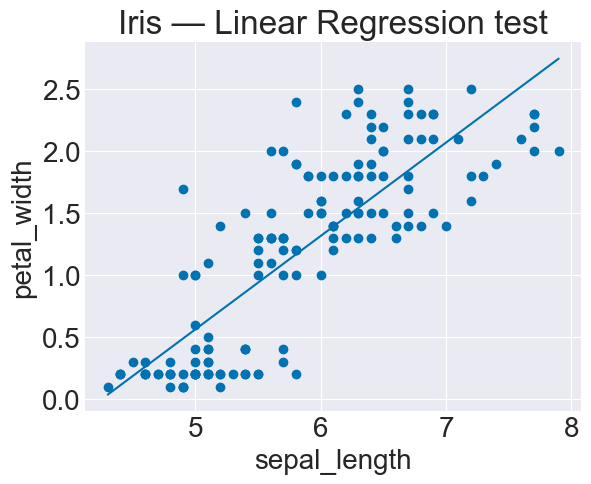

In [38]:
df = pd.read_csv('https://raw.githubusercontent.com/uiuc-cse/data-fa14/gh-pages/data/iris.csv')
iris = df[['sepal_length', 'petal_width']].to_numpy()

num_hidden_units = 1
num_classes = 4
net = RBF_Net(num_classes=num_classes, num_hidden_units=num_hidden_units)
iris_x = np.reshape(iris[:, 0], [len(iris), 1])
iris_y = np.reshape(iris[:, 1], [len(iris), 1])
iris_c = net.linear_regression(iris_x, iris_y)

line_x = np.linspace(iris_x.min(), iris_x.max())
line_y = line_x * iris_c[0] + iris_c[1]
plt.scatter(iris_x, iris_y)
plt.plot(line_x, line_y)
plt.title('Iris — Linear Regression test')
plt.xlabel('sepal_length')
plt.ylabel('petal_width')
plt.show()

### 2d. Train your RBF Network

Implement the following methods then train your neural network! In the cell below, train a RBF network with 10 hidden units on the RBF dev dataset. **If everything is working, you should get >=88% accuracy on the training set and >=89% on the test set.**

- `train`: Determine the optimal output layer weights that fit hidden layer activation using linear regression.
- `predict`: Use trained network (after learning) to predict the class of data.
- `accuracy`: Compute the accuracy by comparing the network predicted and actual class for each data sample.



In [39]:
net = RBF_Net(num_classes=2, num_hidden_units=10)
net.train(rbf_dev_train,y_train)


K-means converged after 7 iterations
K-means converged after 6 iterations
K-means converged after 12 iterations
K-means converged after 10 iterations
K-means converged after 6 iterations


In [40]:
# Training set accuracy
pred_y_train = net.predict(rbf_dev_train)
pred_y_test = net.predict(rbf_dev_test)

In [41]:
# Test set accuracy
acc_train = net.accuracy(y_train,pred_y_train)
acc_test = net.accuracy(y_test,pred_y_test)
print("Train accuracy: ", acc_train)
print("Test accuracy: ", acc_test)

Train accuracy:  0.885625
Test accuracy:  0.8975


## Task 3: Handwritten digit classification: MNIST data

You will train a RBF network on a "real" image dataset of handwritten number digits:
- 60,000 images in training set, 10,000 images in test set.
- Each image is 28x28 pixels.
- The images are grayscale (no RGB colors).
- Each image (data sample) contains ONE of 10 numeric digit $0, 1, 2, \ldots, 8, 9$.

The goal is to train your network so that it can correctly predict the numeric digit in an image.

More information about MNIST: http://yann.lecun.com/exdb/mnist/

### 3a. Load in and look at MNIST dataset

- Use the numpy function `load` to load in the MNIST train/test data and the associated class labels.
- Create a 5x5 grid showing the first 25 images in the dataset. It should "look good" (e.g. turn off tick marks).

In [50]:
x_train = np.load("data/mnist_train_data.npy")
x_test = np.load("data/mnist_test_data.npy")
# x_train = np.array(x_train)
# x_test = np.array(x_test)

y_train = np.load("data/mnist_train_labels.npy")
y_test = np.load("data/mnist_test_labels.npy")
# y_train = np.array(y_train)
# y_test = np.array(y_test)


# x_train = (x_train - np.min(x_train)) / (np.max(x_train)-np.min(x_train))
# x_test = (x_test - np.min(x_test)) / (np.max(x_test)-np.min(x_test))

In [51]:
print(f'Your training set shape is {x_train.shape} and should be (60000, 28, 28).')
print(f'Your training classes shape is {y_train.shape} and should be (60000,).')
print(f'Your test set shape is {x_test.shape} and should be (10000, 28, 28).')
print(f'Your test classes shape is {y_test.shape} and should be (10000,).')

Your training set shape is (60000, 28, 28) and should be (60000, 28, 28).
Your training classes shape is (60000,) and should be (60000,).
Your test set shape is (10000, 28, 28) and should be (10000, 28, 28).
Your test classes shape is (10000,) and should be (10000,).


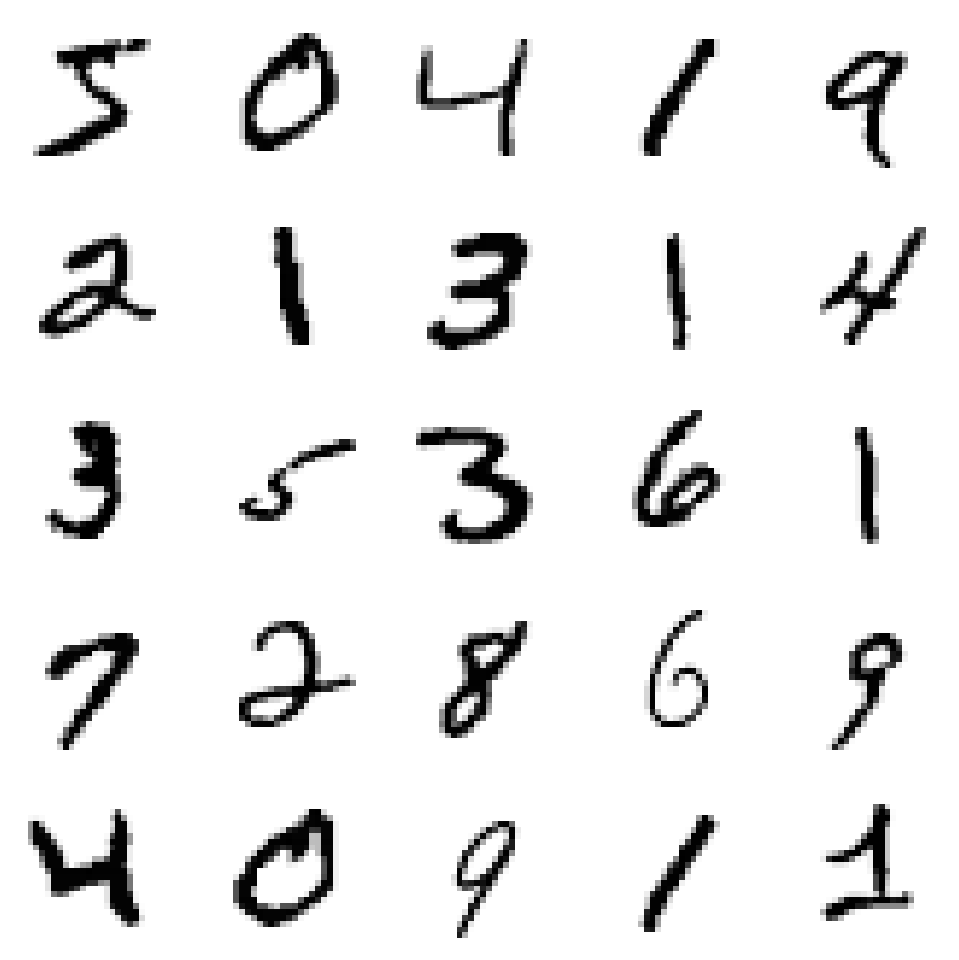

In [52]:
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(10,10))
axs = axs.flatten()

for img, ax in zip(x_train[:25], axs):
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()
plt.show()

### 3b. Preprocess data

- Flatten non-leading dimensions of the train and test sets. For example, the training set should go from (60000, 28, 28) to (60000, 784). **Do not hard code this!** Your code should work for any data with three dimensions.
- Normalize so that the maximum possible value in each image is 1 (and the minimum possible is 0) by dividing by 255.

In [53]:
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1]*x_train.shape[2])
x_train = x_train / 255

x_test = x_test.reshape(x_test.shape[0],x_test.shape[1]*x_test.shape[2])
x_test = x_test / 255

### 3c. Train and assess performance on MNIST

Train a RBF network on MNIST. **Your goal is to get >=90% accuracy on both train and test sets.**

**Tips:**
- Depending on your laptop or machine you are using, training could take many hours if you use the full 60,000 sample training set. Select a subset to train on (e.g. ~1500) that takes a reasonable amount of time (e.g. minutes). You should be able to hit your accuracy goals without too much data, effort, or time.
- Do not pare down the test set (i.e. it should remain at 10,000 samples).
- Use the code below to visualize your hidden layer prototypes to help with debugging (assumes your network is called `mnist_net`). Your prototypes should look like images of certain digits, perhaps a little blurrier.

In [57]:
mnist_net = RBF_Net(num_hidden_units=250,num_classes=10)
idx = np.random.choice(x_train.shape[0], size=1500, replace=False)
x_samp_train = x_train[idx]
y_samp_train = y_train[idx]
mnist_net.train(x_samp_train,y_samp_train)

K-means converged after 9 iterations
K-means converged after 13 iterations
K-means converged after 7 iterations
K-means converged after 6 iterations
K-means converged after 7 iterations


In [58]:
# train acc
pred_y_train = mnist_net.predict(x_train)
pred_y_test = mnist_net.predict(x_test)

In [59]:
# test acc
acc_train = mnist_net.accuracy(y_train,pred_y_train)
acc_test = mnist_net.accuracy(y_test,pred_y_test)
print("Train accuracy: ", acc_train)
print("Test accuracy: ", acc_test)

Train accuracy:  0.91175
Test accuracy:  0.9196


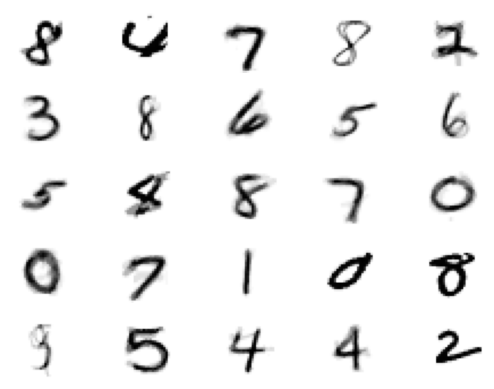

In [60]:
# Visualize network hidden layer prototypes
prototypes = mnist_net.get_prototypes()
prototypes = np.reshape(prototypes, [prototypes.shape[0], 28, 28])

cols = rows = 5
fig, axes = plt.subplots(nrows=rows, ncols=cols)
for i in range(rows):
    for j in range(cols):
        axes[i, j].imshow(prototypes[i*rows + j])
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])

**Question 2:** Which part of the training process takes the longest?

**Answer 2:** 

Making the prediction for the training and test datasets takes the most time.

**Question 3:** What accuracy did you achieve on the training set? List all parameters that you needed to set (e.g. number of training samples, number hidden units, etc).

**Answer 3:** 

I received an accuracy of 91.18% on the training set with 1500 samples. To do so, I had 250 hidden units and 10 classes.

**Question 4:** Using the same parameters to get the training accuracy that you reported in Question 3, what test accuracy did you achieve?

**Answer 4:**

I received an accuracy of 91.96% with the test datset using the same parameters as above.

## Extensions

To receive credit for any extension, you must:
- Not modify / prevent any code from the core project from working (e.g. make a copy before changing). In other words, **the notebook test code should still work!**
- **You must describe what you did and what you found in detail**. This includes a summary of parameter values used in your simulations.
- Include (*labeled!*) plots and/or numbers to present your results.
- Write up your extensions below or in a separate notebook.

**Rule of thumb: one deep, thorough extension is worth more than several quick, shallow extensions!**

### 1) Improve performance on MNIST with PCA

Using all 768 features (pixels) in each image may not be very helpful for classification. For example, pixels around the border are almost always white. Transform the dataset(s) using PCA to compress the number of features before training your RBF network. Experiment with PCA to improve classification accuracy and runtime performance.

### 2) Visualize network predictions

Make visualizations to show and interpret the MNIST network predictions. Lots of possibilities, here are a few specific ideas:
- Make show a grid of test samples labeled with their predicted digit.
- Analyze if the network performance favors accuracy for certain digits and not others.
- Are errors on certain classes correlated in any way? Does it depend on their digit similarity (e.g. 1 looks like a 7, but not a 0).
- Make and interpret a confusion plot.

### 3) Explore parameter space

When training your RBF network on MNIST, you had to pick some parameter values to use by hand. Pick one or more parameters and systematically vary them to quantify their effect on accuracy and simulation time.

In [62]:
import time
for i in range(1,6):
    time1 = time.time()
    mnist_net = RBF_Net(num_hidden_units=50 * i,num_classes=10)
    idx = np.random.choice(x_train.shape[0], size=1500, replace=False)
    x_samp_train = x_train[idx]
    y_samp_train = y_train[idx]
    mnist_net.train(x_samp_train,y_samp_train)
    pred_y_train = mnist_net.predict(x_train)
    pred_y_test = mnist_net.predict(x_test)
    acc_train = mnist_net.accuracy(y_train,pred_y_train)
    acc_test = mnist_net.accuracy(y_test,pred_y_test)
    time2 = time.time()
    print("Train accuracy with ", 50*i, " hidden units: ", acc_train)
    print("Test accuracy with ", 50*i, " hidden units: ", acc_test)
    print("Total time with ", 50 * i, " hidden units: ", time2-time1)

K-means converged after 19 iterations
K-means converged after 17 iterations
K-means converged after 16 iterations
K-means converged after 26 iterations
K-means converged after 14 iterations
Train accuracy with  50  hidden units:  0.8649333333333333
Test accuracy with  50  hidden units:  0.8701
Total time with  50  hidden units:  20.170711994171143
K-means converged after 11 iterations
K-means converged after 10 iterations
K-means converged after 17 iterations
K-means converged after 11 iterations
K-means converged after 13 iterations
Train accuracy with  100  hidden units:  0.8919333333333334
Test accuracy with  100  hidden units:  0.8998
Total time with  100  hidden units:  34.5630407333374
K-means converged after 10 iterations
K-means converged after 9 iterations
K-means converged after 9 iterations
K-means converged after 8 iterations
K-means converged after 10 iterations
Train accuracy with  150  hidden units:  0.9045333333333333
Test accuracy with  150  hidden units:  0.9119
Total

In the cell above, I create five RBF nets with varying numbers of hidden units. I keep track of the accuracy for the training and test dataset predictions as well as the total time it takes to go through all the functions necesssary to calculate the accuracies. This reveals that as the number of hidden units is increased, so too the simulation time and the accuracies increase. Of course, accuracies asymptotically approach 100%, so the increase in the accuracies between each increase in the number of hidden units becomes smaller and smaller. Hence, the accuracies for the training and test datasets go from 86.49% and 87.01%, respecively, with 50 hidden units up to 89.19% and 89.98% with 100 hidden units. This makes for an increase of 2.7% and 2.97%. When the number of hidden units goes from 200 to 250, however, the accuracies only go from 91.32% and 91.74% to 92% and 92.44%. This jump makes for much smaller increase of .68% and .70%. The rate of increase of the time taken to complete the simulation, however, increases as the number of hidden units increases. For example, the jump from 50 to 100 hidden units results in a 14.39 second increase (34.56-20.17) compared to the jump from 200 to 250 hidden units, which produces a difference in the simulation time of 19.28 seconds (80.38-61.10).

In [63]:
for i in range(1,6):
    time1 = time.time()
    mnist_net = RBF_Net(num_hidden_units=150,num_classes=7+i)
    idx = np.random.choice(x_train.shape[0], size=1500, replace=False)
    x_samp_train = x_train[idx]
    y_samp_train = y_train[idx]
    mnist_net.train(x_samp_train,y_samp_train)
    pred_y_train = mnist_net.predict(x_train)
    pred_y_test = mnist_net.predict(x_test)
    acc_train = mnist_net.accuracy(y_train,pred_y_train)
    acc_test = mnist_net.accuracy(y_test,pred_y_test)
    time2 = time.time()
    print("Train accuracy with ", 50*i, " hidden units: ", acc_train)
    print("Test accuracy with ", 50*i, " hidden units: ", acc_test)
    print("Total time with ", 50 * i, " hidden units: ", time2-time1)

K-means converged after 11 iterations
K-means converged after 12 iterations
K-means converged after 13 iterations
K-means converged after 11 iterations
K-means converged after 10 iterations
Train accuracy with  50  hidden units:  0.7548
Test accuracy with  50  hidden units:  0.7556
Total time with  50  hidden units:  50.19343900680542
K-means converged after 13 iterations
K-means converged after 14 iterations
K-means converged after 8 iterations
K-means converged after 12 iterations
K-means converged after 12 iterations
Train accuracy with  100  hidden units:  0.83005
Test accuracy with  100  hidden units:  0.8291
Total time with  100  hidden units:  51.123202085494995
K-means converged after 9 iterations
K-means converged after 10 iterations
K-means converged after 13 iterations
K-means converged after 12 iterations
K-means converged after 10 iterations
Train accuracy with  150  hidden units:  0.9127666666666666
Test accuracy with  150  hidden units:  0.9154
Total time with  150  hidd

In the cell above, I create five RBF nets with varyign numbers of ourput classes, ranging from 8 to 12. This revealed that there is no discernible correlation between the simulation time and the number of output classes, as the times increase and decrease throughotu the iterations. More interestingly, my analysis shows that overestimating the number of classes decreases the accuracy less than underestimating. Thus, when the number of output classes is only 8, the accuracies are 83.05% and 82.91% whereas when the number of output classes is 12, the accuracies are 90.59% and 91.02%.

### 4) Initialization schemes

Research, test out, and quantify the performance of different techniques to set the hidden unit prototypes and sigmas. For example, an alternative way to initialize the prototypes is to perform K-means to cluster each class *separately*. 

### 5) Other datasets

Use your RBF network to classify other datasets.

### 6) SVD-based linear regression

Implement a SVD-based linear regression method, which is both fast and numerically accurate. In the equation $Ac = y$ The weights $c$ can be solved via the following matrix equation: $$c = A^+y$$ where $A^+$ is the pseudo inverse of the matrix of RBF hidden layer activations $A$ (*data matrix*) and the correct classes $y$.

Relying on numpy to figure out the pseudoinverse would be a mini extension, computing the pseudoinverse yourself would be a larger extension.

### 7) Analyze the trained network

Run simulations then analyze and interpret the results. Here are some ideas:
- Visualize and analyze how the prototypes influence the classification results.
- Visualize and analyze how the network weights influence the classification results.

### 8) RBF networks for regression (CS252)

- Analyze the regression neural network's performance in scenarios when the training set is not equal to the training set.
- Explore and analyze how the RBF network could perform regression on a function with several inputs (e.g. $z = f(x, y)$). Test with real or simulated data.
- Explore and analyze how the RBF network could perform regression on a vector valued function with several outputs (e.g. $(y, z) = f(x)$). Test with real or simulated data.